# Machine Learning in Python - Project 1

Due Friday, March 12th by 5 pm (extension resquest approved).
*contributors names:*

*DUNSTAN SASHA*/ UUN: s1802092

*MAK PO WUN*/ UUN: s2081028

*KURIHARA MASAKI* / UUN: s2121881

*NGUYEN CONG* / UUN: s2133124


## 0. Setup

In [113]:
# Install required packages
!pip install -q -r requirements.txt

In [114]:
# Add any additional libraries or submodules below

# Display plots inline
%matplotlib inline

# Data libraries
import pandas as pd
import numpy as np

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder

# Plotting defaults
plt.rcParams['figure.figsize'] = (8,5)
plt.rcParams['figure.dpi'] = 80

# sklearn modules
import sklearn

In [115]:
# Load data
d = pd.read_csv("the_office.csv")

,season,episode,episode_name,director,writer,imdb_rating,total_votes,air_date,n_lines,n_directions,n_words,n_speak_char,main_chars
0,1,1,Pilot,Ken Kwapis,Ricky Gervais;Stephen Merchant;Greg Daniels,7.6,3706,2005-03-24,229,27,2757,15,Angela;Dwight;Jim;Kevin;Michael;Oscar;Pam;Phyl...
1,1,2,Diversity Day,Ken Kwapis,B.J. Novak,8.3,3566,2005-03-29,203,20,2808,12,Angela;Dwight;Jim;Kelly;Kevin;Michael;Oscar;Pa...
2,1,3,Health Care,Ken Whittingham,Paul Lieberstein,7.9,2983,2005-04-05,244,21,2769,13,Angela;Dwight;Jim;Kevin;Meredith;Michael;Oscar...
3,1,4,The Alliance,Bryan Gordon,Michael Schur,8.1,2886,2005-04-12,243,24,2939,14,Angela;Dwight;Jim;Kevin;Meredith;Michael;Oscar...
4,1,5,Basketball,Greg Daniels,Greg Daniels,8.4,3179,2005-04-19,230,49,2437,18,Angela;Darryl;Dwight;Jim;Kevin;Michael;Oscar;P...
5,1,6,Hot Girl,Amy Heckerling,Mindy Kaling,7.8,2852,2005-04-26,346,39,3028,13,Angela;Dwight;Jim;Kevin;Michael;Oscar;Pam;Ryan...


## 1. Introduction


NBC Universal wants to create a special reunion episode for the show called "The Office" and they aim to have it rated as high as possible on the IMDb website. For that to happen, they would like to understand the reasons behind the popularity of a few episodes (based on imdb rating) compare to the others.  

Our team will utilize data provided by the studio to develop a model which can predict `imdb_ratings` based on the different number of features (or factors which influence the rating) such as 'directors', 'total votes', etc. In total, there are 13 different features which may or may not contribute to how the show is rated. Therefore, we perform a quick correlations test. The test allows us to decide whether to keep or discard a few features with low correlations concerning to the `imdb_ratings`.

The kept features will be transformed via feature engineering using dummy coding. Dummy coding transforms our independent variables (x) into dummy variables which take a boolean value of either 1 or 0 depending on whether that variable is present or not in a certain episode or seasons. 

Feature transformation undoubtedly increases the total number of features. To counter this, we will combine some features into a group based on the frequencies in which they appear. Features with relatively high frequency will be divided into groups with different conditions. On the other hand, features with frequency levels below a certain threshold will be discarded. With this, we managed to reduce the total number of features down to a manageable size. 

The next step is to fit a regression model onto the transformed data. Having tested the data onto different types of models and comparing the root mean square error(RMSE), our team decided to prioritize Lasso regression. 

Finally, in order to optimize the Lasso model, our team will perform a grid-search method to find the tuning parameter alpha that can minimize the RMSE.




## 2. Exploratory Data Analysis and Feature Engineering

### Preprocessing


Using the schrutepy package, we derive a new feature called `char_most_lines` which represents the character with most lines in each episode.

In [116]:
from schrutepy import schrutepy
df = schrutepy.load_schrute()

seas_eps = list(d.groupby(['season', 'episode']).groups.keys())
char_most_lines=[]
for (s,e) in seas_eps:
    se = df[(df['season'].values == s) & (df['episode'].values == e)].groupby('character').count()[['index']]
   
    char_most_lines.append(se['index'].idxmax())

d['char_most_lines']=char_most_lines

To simplify `air_date`, we group the dates according to months and rename the column as `air_month`.

In [117]:
#Replacing 'air_date' with 'air_month'. The months June, July and August are excluded since no episodes are aired during those months
month_list=[('-01-','Jan'),('-02-','Feb'),('-03-', 'Mar'),('-04-','Apr'),('-05-', 'May'),('-09-', 'Sep'),('-10-','Oct'),('-11-','Nov'),('-12-','Dec')]

for i,j in month_list:
    
    ind=d.index[d['air_date'].str.contains(i)]

    for k in d.loc[ind]['air_date']:
        d['air_date']=d['air_date'].replace(k,j)
d=d.rename({'air_date':'air_month'}, axis=1)


### Exploratory Data Analysis

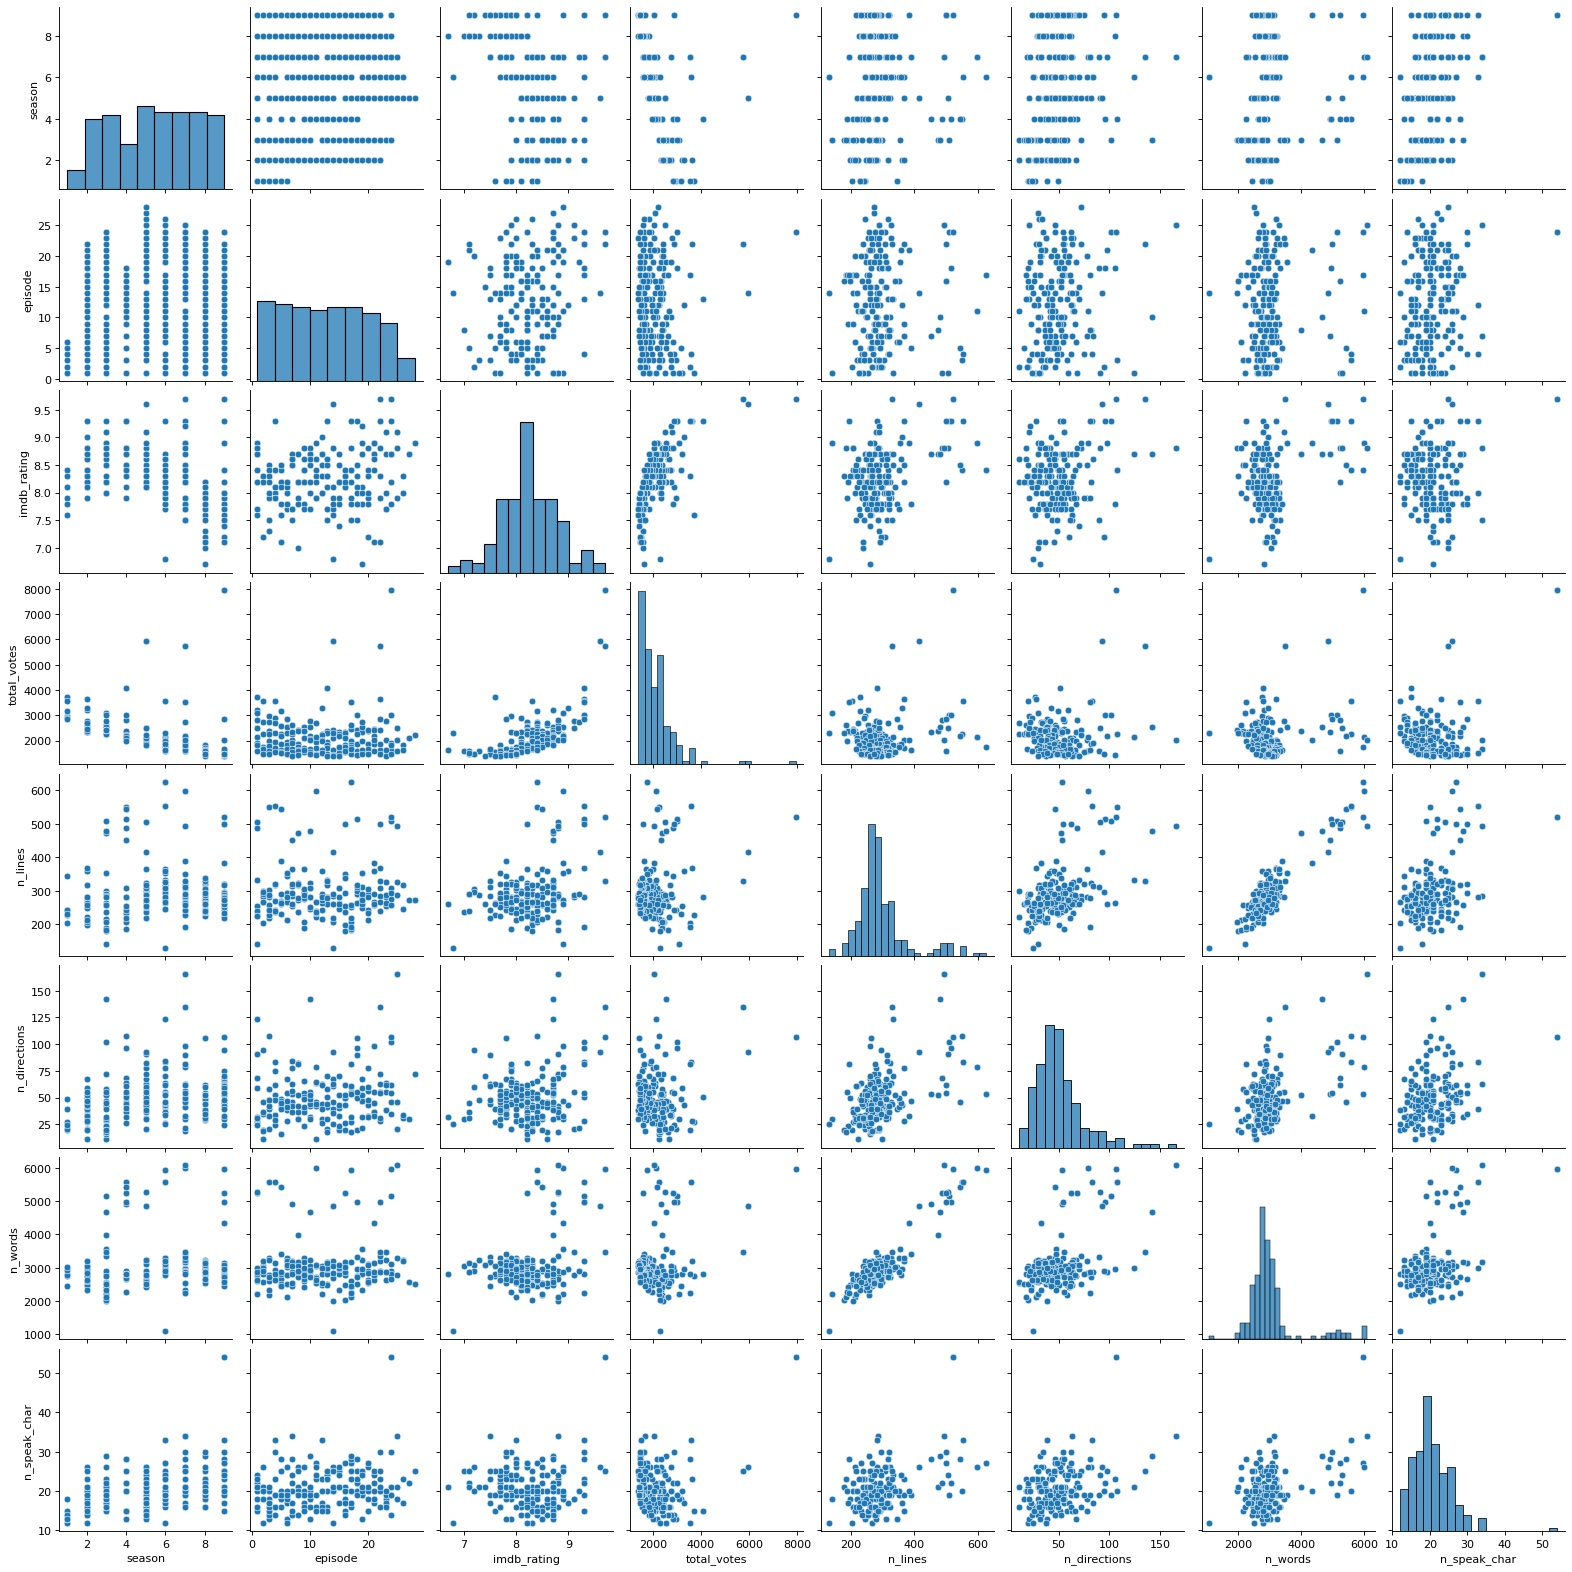

In [118]:
# show a pair plot of origina data
sns.pairplot(d)

The scatter plot for `imdb_rating` vs `total_votes` seems to suggest a non-linear relationship while the scatter plot for `n_words` vs `n_lines` indicates that there is a linear relationship with positive slope. The `season` variable appears to be categorical. `total_votes` seems to decrease with `season` while `imdb_rating` appears to fluctuate for each season. There is no clear pattern for the scatter plots of `imdb_rating` vs `n_lines`/`n_directions`/`n_words`/`n_speak_char`. The distributions for the numeric variables are quite skewed, we can therefore apply a log transformation to these variables.

In [119]:
#Applying log transformation due the fact that some distribution is skewed. 
d['total_votes']=np.log(d['total_votes'])
d['n_lines']=np.log(d['n_lines'])
d['n_directions']=np.log(d['n_directions'])
d['n_words']=np.log(d['n_words'])
d['n_speak_char']=np.log(d['n_speak_char'])


We now look at the correlation between variables by plotting the correlation heat map below:

<AxesSubplot:>

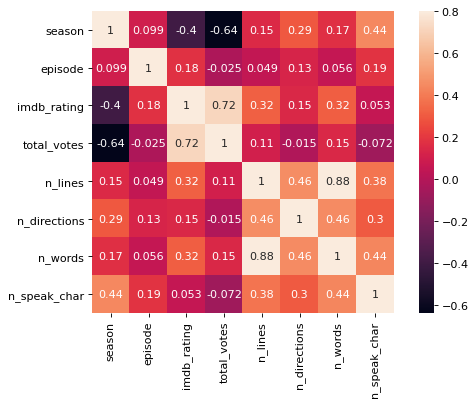

In [120]:
#Perform a correlation test on the data and present it in the form of a correlation matrix.
corrmat = d.corr()
sns.heatmap(corrmat, vmax=.8, square=True, annot=True)


Based on the plot above, we observe that the correlation between `total_votes` and `imdb_rating` is quite high. The correlation between `imdb_ratimg` and the other variables seem to be low. We employ the filter method for feature selection, whereby variables whose correlation value(taken to be the absolute value) are lower than a certain threshold is dropped. In this case, we set the threshold to be 0.20, resulting in the variables `episode`, `n_directions` and `n_speak_char` to be dropped.

In [121]:
#This code allow us to "drop" the features which show little or no correlation to the outcomes 
d=d.drop(['episode', 'n_directions', 'n_speak_char'], axis=1)

Looking at the correlation between predictor variables, there is a rather high positive correlation between the variables `n_lines` and `n_words`. The variable  `season` seems to have a moderately strong negative correlation with `total_votes`. This indicates that there could be multicollinearity relationship between our variables.  

Next, we perform a series of boxplot to visualise the relationships between `imdb_rating` and other categorical variables such as `air_month` and `char_most_lines`.

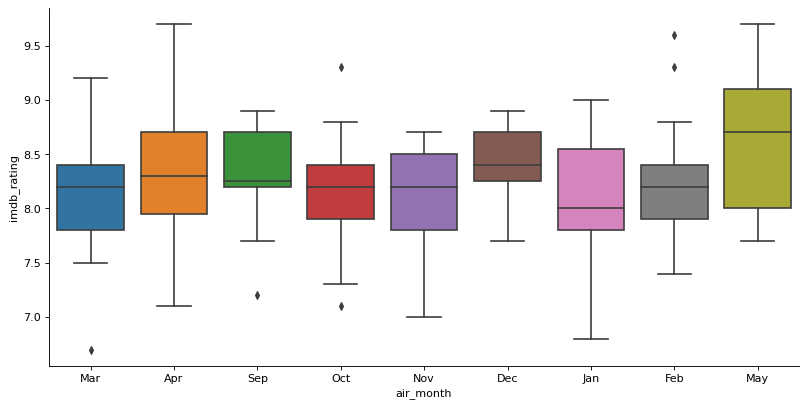

In [122]:
sns.catplot(
    x = "air_month",
    y = "imdb_rating",
    kind = "box",
    data = d,
    aspect = 2
)

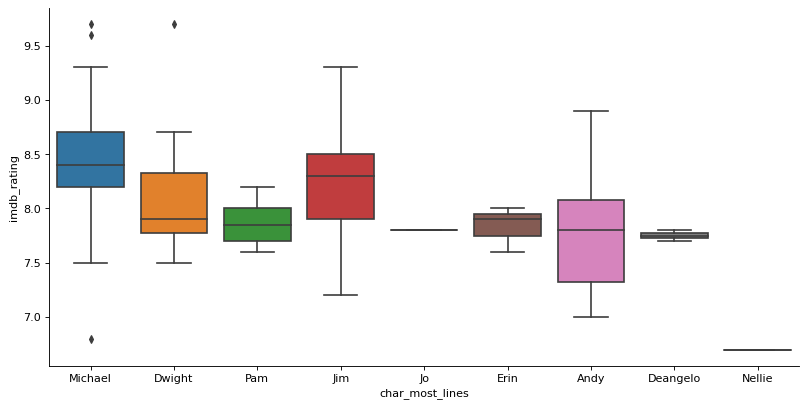

In [123]:
sns.catplot(
    x = "char_most_lines",
    y = "imdb_rating",
    kind = "box",
    data = d,
    aspect = 2
)

The plots for other categorical features like `director`, `writer` and `main_chars` are extremely disordered and thus excluded. This is mainy due to the fact that these categorical features consist of a large number of levels, and also some errors like misspellings and duplicates of names. In the following section, we will be correcting the errors and dummy coding these categorical features.

In [124]:
#Fixing typos in the naming of some directors
d['director']=d['director'].replace('Ken Wittingham', 'Ken Whittingham')
d['director']=d['director'].replace('Greg Daneils', 'Greg Daniels')
d['director']=d['director'].replace('Charles McDougal', 'Charles McDougall')
d['director']=d['director'].replace('Paul Lieerstein', 'Paul Lieberstein')
d['director']=d['director'].replace('Claire Scanlong', 'Claire Scanlon')


In [125]:
def group_to_bool (data, column_name, role, make_list = False):
    d = data
    # make a list of main characters.
    person_list = d[column_name].str.split(';', expand=True)
    # data frame to list
    person_list = person_list.values.tolist()
    # convert to one-dimention
    person_list = sum(person_list,[])
    #  convert the given set into list
    person_list = list(set(person_list))
    # delete none value
    person_list = list(filter(None, person_list))
    
    # loop to add column with bool for checking person's exsistence
    for i in range(len(person_list)):
        # extract name for making bool
        name = person_list[i]
        # make bool by referring given column
        dd = d[column_name].str.contains(name)
        # add column to original data
        d[role+name] = dd
        # convert True & False to 1 & 0 
        d[role+name] = d[role+name].astype(int)
        # person list rewrite with role
        person_list[i] = role+name
    
    if make_list == False:
        return d
    else:
        return d, person_list

### Dummy coding the categorical features: `director`, `writer`, `main_chars`, `char_most_lines`, `air_month`

Now, we will perform feature engineering on the categorical variables by using dummy coding.

In [126]:
d, writercol = group_to_bool(d, 'writer', 'writer ', make_list = True)
d, directorcols = group_to_bool(d, 'director', 'director ' ,make_list = True)
d = group_to_bool(d, 'main_chars', 'main_chars ')

,season,episode_name,director,writer,imdb_rating,total_votes,air_month,n_lines,n_words,main_chars,...,main_chars Angela,main_chars Ryan,main_chars Michael,main_chars Kevin,main_chars Dwight,main_chars Stanley,main_chars Meredith,main_chars Erin,main_chars Kelly,main_chars Oscar
0,1,Pilot,Ken Kwapis,Ricky Gervais;Stephen Merchant;Greg Daniels,7.6,8.217708,Mar,5.433722,7.921898,Angela;Dwight;Jim;Kevin;Michael;Oscar;Pam;Phyl...,...,1,1,1,1,1,1,0,0,0,1
1,1,Diversity Day,Ken Kwapis,B.J. Novak,8.3,8.179200,Mar,5.313206,7.940228,Angela;Dwight;Jim;Kelly;Kevin;Michael;Oscar;Pa...,...,1,1,1,1,1,1,0,0,1,1
2,1,Health Care,Ken Whittingham,Paul Lieberstein,7.9,8.000685,Apr,5.497168,7.926242,Angela;Dwight;Jim;Kevin;Meredith;Michael;Oscar...,...,1,1,1,1,1,1,1,0,0,1
3,1,The Alliance,Bryan Gordon,Michael Schur,8.1,7.967627,Apr,5.493061,7.985825,Angela;Dwight;Jim;Kevin;Meredith;Michael;Oscar...,...,1,1,1,1,1,1,1,0,0,1
4,1,Basketball,Greg Daniels,Greg Daniels,8.4,8.064322,Apr,5.438079,7.798523,Angela;Darryl;Dwight;Jim;Kevin;Michael;Oscar;P...,...,1,1,1,1,1,1,0,0,0,1


The resulting dataframe has expanded to 123 columns mainly due to a large number of writers and directors. This is not ideal as this number is almost as big as the number of observations we have (186), which may lead to the Curse of Dimensionality. Therefore, instead of dummy coding every writer, we group the writers according to the frequency they appear in the data set:

`writer_high`: writers that have written 15 or more episodes; `writer_mid`: writers that have written 10 or more but less than 15 episodes'; `writer_midlow`: writers that have written 5 or more but less than 10 episodes; `writer_low`: writers that have written less than 5 episodes

As for directors, we keep the top 10 directors based on the number of episodes they have directed, and group the remaining directors in the `other_directors` category. 


In [128]:
# Create empty categories in order to be filled in later by the number of writers who satisfy a certain conditions. 
writer_high=[]
writer_mid=[]
writer_midlow=[]
writer_low=[]

for i in writercols:
    if (d[i].sum() >= 15):
        writer_high.append(i)
    elif (d[i].sum()>= 10 and d[i].sum() < 15):
        writer_mid.append(i)
    elif (d[i].sum()>= 5 and d[i].sum()< 10):
        writer_midlow.append(i)
    else:
        writer_low.append(i)

d['writer_high']=d[writer_high].sum(axis=1)
d['writer_mid']=d[writer_mid].sum(axis=1)
d['writer_midlow']=d[writer_midlow].sum(axis=1)
d['writer_low']=d[writer_midlow].sum(axis=1)

writerlevel=['writer_high', 'writer_mid', 'writer_midlow', 'writer_low']
for k in writerlevel:
    dd=d[k]>0
    d[k]=dd
    d[k]=d[k].astype(int)
d=d.drop(writercols, axis=1)

In [129]:
other_directors=list((d[directorcols].sum()).sort_values(ascending=False).index[11:])
d['other_directors']= d[other_directors].sum(axis=1)
dd=d['other_directors']>0
d['other_directors']=dd
d['other_directors']=d['other_directors'].astype(int)

d=d.drop(other_directors, axis=1)

We now dummy code the rest of the categorical variables (`air_month`, `season` and `char_most_lines`). We will also be excluding the `episode_name` variable from our model since we do not find it that useful to predict IMDb ratings from the names of episodes.

In [130]:
d=pd.get_dummies(d, columns=['air_month','char_most_lines','season'])
d=d.drop(['director','writer','episode_name','main_chars'], axis=1)
#d.head(5)

,imdb_rating,total_votes,n_lines,n_words,director Randall Einhorn,director Paul Feig,director Matt Sohn,director Greg Daniels,director David Rogers,director Paul Lieberstein,...,char_most_lines_Pam,season_1,season_2,season_3,season_4,season_5,season_6,season_7,season_8,season_9
0,7.6,8.217708,5.433722,7.921898,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1,8.3,8.179200,5.313206,7.940228,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,7.9,8.000685,5.497168,7.926242,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
3,8.1,7.967627,5.493061,7.985825,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
4,8.4,8.064322,5.438079,7.798523,0,0,0,1,0,0,...,0,1,0,0,0,0,0,0,0,0


## 3. Model Fitting and Tuning

We wil be using the helper functions provided in Workshop 5, namely `get_coefs()` and `model_fit()`:

In [131]:
#Helper function obtained from Workshop 5 
from sklearn.metrics import mean_squared_error
def get_coefs(m):
    # If pipeline, use the last step as the model
    if (isinstance(m, sklearn.pipeline.Pipeline)):
        m = m.steps[-1][1]
    
    
    if m.intercept_ is None:
        return m.coef_
    return np.concatenate([[m.intercept_], m.coef_])

def model_fit(m, X, y, plot = False):
    y_hat = m.predict(X)
    rmse = mean_squared_error(y, y_hat, squared=False)
    
    res = pd.DataFrame(
        data = {'y': y, 'y_hat': y_hat, 'resid': y - y_hat}
    )
    
    if plot:
        plt.figure(figsize=(12, 6))
        
        plt.subplot(121)
        sns.lineplot(x='y', y='y_hat', color="grey", data =  pd.DataFrame(data={'y': [min(y),max(y)], 'y_hat': [min(y),max(y)]}))
        sns.scatterplot(x='y', y='y_hat', data=res).set_title("Fit plot")
        
        plt.subplot(122)
        sns.residplot(x='y', y='resid', data=res, lowess=True, color="g", label= "Residual plot")
        #sns.scatterplot(x='y', y='resid', data=res).set_title("Residual plot")
        
        
        plt.subplots_adjust(left=0.0)
        
        plt.suptitle("Model rmse = " + str(round(rmse, 4)), fontsize=16)
        plt.show()
    
    return rmse

Before we begin fitting the model, we split the data into training (X_train, y_train) and test sets (X_test, y_test) using a 70/30 split. This results in the training set having 130 observations, leaving 56 observations for the test set.

In [132]:
#Split data into training and test sets
y=d.imdb_rating
X=d.drop(columns=['imdb_rating'])
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=15)

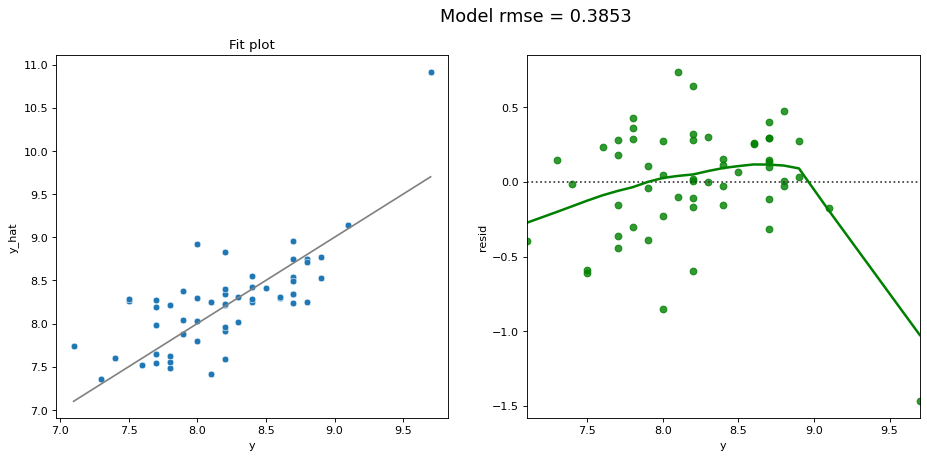

Regression score on test data is 0.4076002703688347
Regression score on train is 0.8863340652138891


In [134]:
# A. Using Linear Regression Model as Baseline Model
from sklearn.linear_model import LinearRegression
lm = LinearRegression(fit_intercept=False).fit(X_train, y_train)
model_fit(lm, X_test, y_test)

#linear model score on traiing data and test data.
print("Regression score on test data is", lm.score(X_test, y_test))
print("Regression score on train is", lm.score(X_train, y_train))

Based one the regression score, the current model overfit the training data and underfit the testing data. As a result, it will not perform well when given a new data set. Thus, it is advisable that we do not use the model above for predicting `imdb_ratings`. 

After trying out a few models including linear regression, polynomial regression (looping over different degrees of the numerical variables without any interactions), Ridge regression, Kernel Ridge regression and Lasso regression, we decided that our model of choice would be the Lasso regression. As mentioned previously in the section for exploratory data analysis, there may be issues relating to multicollinearity. Therefore, using regularization (either Ridge or Lasso) could help alleviate this issue. We were also concerned with the problems of overfitting or underfitting. If our model is too simple and has very few parameters then it may have high bias and low variance (underfitting). On the other hand, if our model has a large number of parameters then it is going to have high variance and low bias (overfitting). It is not possible to achieve a model with low variance and low bias. In fact, we need to find a good balance between bias and variance (bias-variance tradeoff). By choosing a regularization method, we are able to decrease their variance at the cost of increasing bias.

Moreover, despite our earlier efforts in reducing the number of features in the previous section (63 in total), the total number of features is still quite large, especially when comparing it against the number of observations for the training set (130). We wish to further narrow down the number of features to enhance interpretability by using a regression analysis method that not only performs regularization, but also variable selection. In this case, the Lasso meets these requirements. 


We first try to fit a Lasso regression with the tuning parameter `alpha` = 0.20 (chosen arbitrarily) which determines the weight of the  $\ell_2$ penalty. After comparing the results between Lasso regression models with and  without standardizing the numerical variables, we obtain lower root mean squared error (rmse) for the model with standardization. Also, it is recommended that all features are standardised before fitting using Lasso regression so that the solution does not depend on the measurement scale. The standardization step is thus included in the pipeline (`StandardScaler()`).

In [135]:
from sklearn.linear_model import Lasso
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.preprocessing import StandardScaler

l = make_pipeline(
    StandardScaler(),
    Lasso(alpha=0.20)
).fit(X_train, y_train)


We obtain the following results:

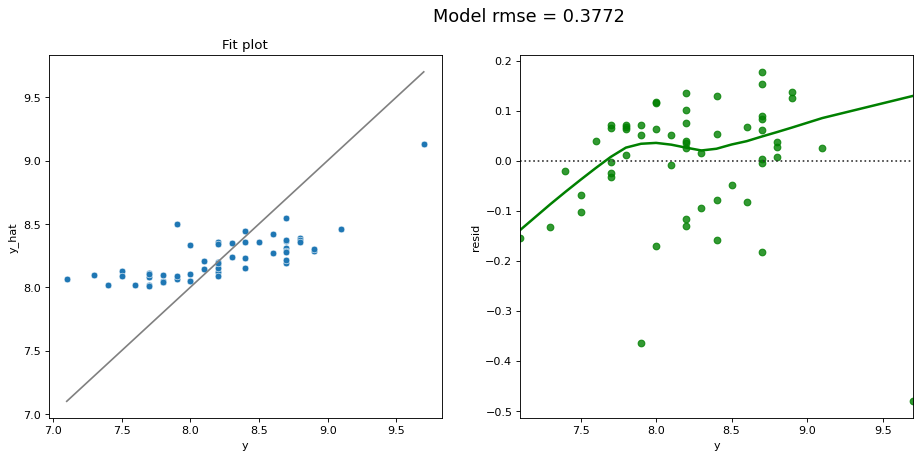

lasso rmse: 0.3772125190659439


{'total_votes': (0.1813738719317472,),
 'n_lines': (0.0,),
 'n_words': (0.0,),
 'director Randall Einhorn': (-0.0,),
 'director Paul Feig': (0.0,),
 'director Matt Sohn': (-0.0,),
 'director Greg Daniels': (0.0,),
 'director David Rogers': (-0.0,),
 'director Paul Lieberstein': (-0.0,),
 'director Ken Kwapis': (0.0,),
 'director B.J. Novak': (-0.0,),
 'director Jeffrey Blitz': (-0.0,),
 'director Ken Whittingham': (0.0,),
 'director Charles McDougall': (0.0,),
 'main_chars Andy': (0.0,),
 'main_chars Phyllis': (0.0,),
 'main_chars Toby': (0.0,),
 'main_chars Creed': (0.0,),
 'main_chars Darryl': (-0.0,),
 'main_chars Jim': (0.0,),
 'main_chars Pam': (0.0,),
 'main_chars Angela': (-0.0,),
 'main_chars Ryan': (-0.0,),
 'main_chars Michael': (0.0,),
 'main_chars Kevin': (-0.0,),
 'main_chars Dwight': (0.0,),
 'main_chars Stanley': (0.0,),
 'main_chars Meredith': (0.0,),
 'main_chars Erin': (-0.0,),
 'main_chars Kelly': (0.0,),
 'main_chars Oscar': (-0.0,),
 'writer_high': (0.0,),
 'writer

In [136]:
#print rmse and display fit plot and residual plot
print("lasso rmse:", model_fit(l, X_test, y_test, plot=True))

It is obvious from the fit plot that the model does not perform well at all- the points do not align with the straigh line at all. From the residual plot, we see that the model tends to overestimate for lower values of IMDb ratings and underestimate for higher values of IMDb ratings. As for the estimated coefficients, all but the coefficient for `total_votes` are shrunk to 0, this model fails to be informative. Perhaps we can tune the `alpha` parameter to find the most optimal Lasso regression model. We do this using GridSearchCv.

In [137]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold


alphas = np.linspace(0.01, 1, num=100)

l_gs = GridSearchCV(
    make_pipeline(
        StandardScaler(),
        Lasso()
    ),
    param_grid={'lasso__alpha': alphas},
    cv=KFold(5, shuffle=True, random_state=1234),
    scoring="neg_root_mean_squared_error"
).fit(X_train, y_train)

We obtain the following results using GridSearchCv:

In [138]:
print( "best tuning alpha:", l_gs.best_params_['lasso__alpha'])
print( "best rmse :", l_gs.best_score_ * -1)

best tuning alpha: 0.03
best rmse : 0.3189933226278793


Our final model is therefore the Lasso regression model with tuning parameter `alpha` = 0.01. The coefficients for this model are given below:

In [139]:
l_gs_coefs = get_coefs(l_gs.best_estimator_)[1:]
dict(zip(X.columns, zip(l_gs_coefs)))

{'total_votes': (0.3504787363836297,),
 'n_lines': (0.07692901536906813,),
 'n_words': (0.0,),
 'director Randall Einhorn': (-0.0,),
 'director Paul Feig': (0.0,),
 'director Matt Sohn': (-0.0,),
 'director Greg Daniels': (0.0,),
 'director David Rogers': (-0.0,),
 'director Paul Lieberstein': (-0.0,),
 'director Ken Kwapis': (-0.0,),
 'director B.J. Novak': (0.0,),
 'director Jeffrey Blitz': (-0.0,),
 'director Ken Whittingham': (-0.0,),
 'director Charles McDougall': (0.016724648450323377,),
 'main_chars Andy': (0.00920145891696371,),
 'main_chars Phyllis': (-0.0,),
 'main_chars Toby': (0.0,),
 'main_chars Creed': (0.0,),
 'main_chars Darryl': (-0.0,),
 'main_chars Jim': (0.08844698339293966,),
 'main_chars Pam': (-0.0,),
 'main_chars Angela': (-0.0,),
 'main_chars Ryan': (-0.0,),
 'main_chars Michael': (0.0,),
 'main_chars Kevin': (-0.0,),
 'main_chars Dwight': (0.0,),
 'main_chars Stanley': (0.0,),
 'main_chars Meredith': (-0.0,),
 'main_chars Erin': (0.0,),
 'main_chars Kelly': (0

The rmse for the model is given as:

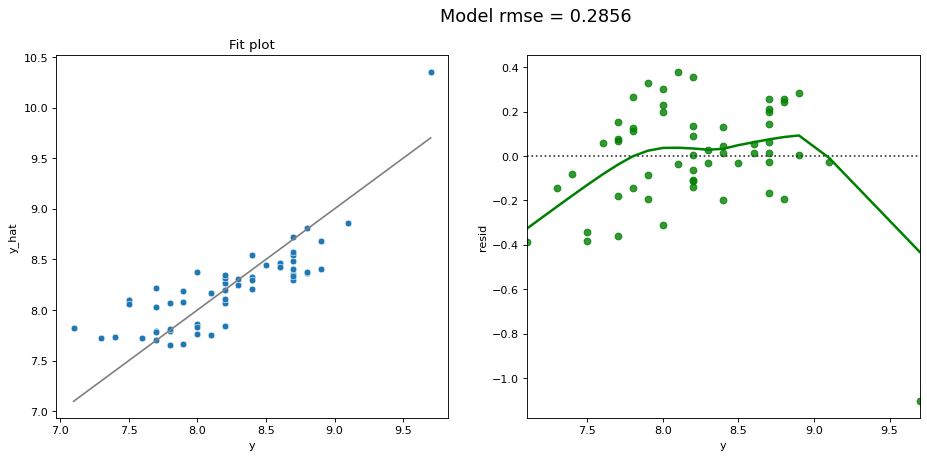

Lasso score on test data is 0.675
Lasso score on train data is 0.794


In [140]:
model_fit(l_gs.best_estimator_, X_test, y_test, plot=True)

# Model score after regularization and GridSearch
print("Lasso score on test data is", round(l_gs.best_estimator_.score(X_test, y_test),3))
print("Lasso score on train data is", round(l_gs.best_estimator_.score(X_train, y_train),3))

Based on the model scores, the Lasso model with the optimized alpha (through GridSearch) performs better than the regular linear model above.  
We could also assess how far the true generalization error might deviate from the average test error, which is indicated by Average test error±2(standard error of average test error)Average \ test \ error \pm 2(standard \ error \ of\ average\ test\ error)Average test error±2(standard error of average test error). We use the squared error loss for our model, in this case, the average test error is just the mean squared error.

In [141]:
#Compute the average test error
y_hat = l_gs.best_estimator_.predict(X_test)
avg_test_error = mean_squared_error(y_test, y_hat)

#Compute the standard error of the average test error
squared_error = (y_hat-np.array(y_test))**2
se_average_test_error = np.sqrt(np.var(squared_error,ddof=1)/len(squared_error)) 
#ddof=1,the sample variance is used to estimate the variance of the test errors

print("The average test error is ", round(avg_test_error,4))
print("The standard error of the average test error is ", round(se_average_test_error,4))
print("The true generalization error might deviate from the average test error by a magnitude of approximately ", round(2*se_average_test_error,4))

The average test error is  0.0816
The standard error of the average test error is  0.0152
The true generalization error might deviate from the average test error by a magnitude of approximately  0.0304


## 4. Discussion & Conclusions


## Overview of the final model



For our final model, we predict IMDb rating of a given episode using the following features:
- `total_votes`: Number of ratings for episode on IMDb      
- `n_lines`: Number of spoken lines in episode
- `n_words`: Number of dialog words in episide 
- `directors`: Episode directors (we pick the top 10 directors based on their experience directing the most number of episodes)
- `writers`: Episode writers (we split the writers into 4 groups based on the number of episodes they wrote)
- `main_chars`: Main characters appearing in episode (main characters were determined to be characters appearing in more than 1/2 of the episodes)
- `season`: Season number of the episode
- `air_month` : The month the episode was aired
- `char_most_lines`: Characters with most lines in the episode

For each feature, we obtain a 'weight' value, which we can interpret as the relative importance of how each feature affects the IMDb rating. We will be giving recommendations based on these weights. 

As high dimensionality may cause an increase in test error and in the raw data we have noisy features which are not truly associated with the popularity or the IMDb ratings, we have done feature engineering in order to analyse the data which we think are truly associated with the ratings. Also, Lasso helps in feature selection which is very useful for analysing this dataset while Rdige regression cannot perform this kind of selection. Therefore, we could ensure that the reliability of the model would not be affected by the noisy features. 

As we observe from the weights of the inputs, most of the weights are close to 0 while just very few of them have more substantial weights. This is one of the reasons why we choose Lasso. In order to avoid overfitting, Lasso helps us eliminating irrelevant variables which are irrelevant to the IMDb ratings by the tuning parameters $\alpha$. This also improves the interpretability and reduces the complexity of the model.

Finally, we have assessed how accurate our model is able to predict outcome values for previously unseen data, which is indicated by the average test error. We obtain an average test error of approximately 0.0816, which is fairly acceptable. We also assessed how the true accuracy would deviate from our current accuracy, and we obtained a low deviation of approximately 0.0152. This means that for our model the highest average test error we may get is $0.0816+0.0304=0.112$ 


## Recommendations

From the model, we observe that the number of spoken lines in an episode has a small positive effect on the IMDb rating, therefore a script with more lines may contribute to the IMDb ratings slightly. Among the top 10 directors, only Charles McDougall is associated with positive weight, that means choosing him to direct the reunion episode may have a slight positive effect on the IMDb rating. As for the writers, we observe that all 4 categories (i.e. `writer_high` (wrote 15 or more episodes), `writer_mid` (wrote 10 or more but less than 15 episodes), `writer_midlow` (wrote 5 or more but less than 10 episodes) and `writer_low` (wrote less than 5 episodes)) have weights 0, meaning that choosing writers from either category will not affect the IMDb rating significantly. However, it may be sensible to consider writers who are more experienced. 

Since it is a reunion episode, it is preferable to include all main characters. However to improve the ratings, our model have suggested that we should only give a few characters with the most screen time. The main characters that are associated with positive weights are Jim, Kelly and Andy, with Jim having the highest weight followed by Kelly then Andy; this means increasing the screen time for these characters may increase IMDb ratings. Furthermore, by looking at the characters with most lines per episode, we can deduce that Andy and Nellie are associated with negative weights, with Nellie's weight being much more negative than Andy's. Hence, if Nellie appears as the character who spoken the most lines, this could potentially lead to a decrease in the episode ratings. Eventhough, Andy's weight is negative, its magnitude is relatively small; so giving him more lines won't affect the rating significantly. Additionally, since the associated weights are 0 for other characters such as (Deangelo, Dwight, Erin, Jim, Jo, Michael and Pam); it is also safe to give more lines to those other characters. 

By looking at how each season effects the IMDb rating using our model, we observe that season 1, season 2 and season 8 are associated with negative weights, with season 1 having the most negative impact on IMDb rating followed by season 8 then 2. In contrast to this, seasons 5 and 7 are associated with positive weights, with season 5 being more positive than season 7. With this information, one can examine how the negatively weighted seasons (1,2 and 8) differ from the positively weighted seasons (5 and 7). Perhaps season 5 and 7 are characterised by elements like characters, writing, plot, etc. that viewers may prefer over some elements that are found in season 1,2 and 8. 

Another feature that we look at was the month that the episodes were aired. Our results indicate that months like May and December have positive weights, while October has negative weight. Similar to season, one can compare how certain elements differ between episodes aired in May/December and episodes aired in October. From this, we can infer that there could be a possibility that viewers enjoy festive/Christmas themed that are aired in December. 

Finally, we observe that the total votes have the biggest positive effect on IMDb rating relative to all other features. Its effect may be 10 times as big as some of the features. At the end of the day, the number of ratings contributes the most to the IMDb rating therefore it is important to ensure that there is a sufficient number of voters. This may be an issue since the show has seen a drop in number of ratings throughout each season, which may indicate that people are losing interest. Therefore, it is essential that the reunion episode gains a large audience and this may be achieved by employing good promotion or marketing strategy prior to the episode's release (releasing teaser, using social media platforms, advertisements etc.) to increase anticipation. In addition, increaing the number of platforms (streaming services) whrereby the reunion episode (or even the whole show) is aired may also expand the fan base.

## Limitations
It is difficult to determine the effects from the individual writers and directors as there are several writers and directors for each episode and they contribute to the same episode. A similar limitation occurs at 'season' and 'episode' since not all the TV show has the same number of seasons and episodes. This may affect the accuracy of prediction. Moreover, the sample size is limited. If we have inputs variables such as names of writers or directors which are not included in this limited dataset, we could not predict the ratings based on the inputs. However, there are many writers or directors from different TV show. The model restricts the data that we could use for prediction. Additionally, the setting of a threshold such as 15 or 10 for grouping writer and director is arbitrary. We made sure that our setting is surely one of the reasonable ways for grouping in terms of the number of writer and director in each group but is still debatable. 

## 5. Convert Document

In [143]:
# Run the following to render to PDF
!jupyter nbconvert --to markdown project1.ipynb

[NbConvertApp] Converting notebook project1.ipynb to markdown
[NbConvertApp] Support files will be in project1_files/
[NbConvertApp] Making directory project1_files
[NbConvertApp] Making directory project1_files
[NbConvertApp] Making directory project1_files
[NbConvertApp] Making directory project1_files
[NbConvertApp] Making directory project1_files
[NbConvertApp] Making directory project1_files
[NbConvertApp] Making directory project1_files
[NbConvertApp] Writing 45484 bytes to project1.md


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=855a35f7-30d3-46a8-952e-1f6c0ecba2f3' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>